In [1]:
%run run_xclass_ch3cn.py


Start function myXCLASS:


Creating job directory for function myXCLASS: /orange/adamginsburg/software/XCLASS-Interface/run/myXCLASS/job__03-09-2021__20-42-52__35053634/ .. done!

All files of the current myXCLASS run are stored here!


Set environment variable MAGIXTempDirectory =  /orange/adamginsburg/software/XCLASS-Interface/programs/MAGIX/temp/
Analyze molfit file .. done!


Check, if names of molecules in molfit file are included in XCLASS database .. done!




Import calculated myXCLASS spectrum .. done!

Read in intensities for each molecule and for each component .. done!

Read in optical depths for each molecule and for each component .. done!

All files of the current myXCLASS run are stored in the job directory /orange/adamginsburg/software/XCLASS-Interface/run/myXCLASS/job__03-09-2021__20-42-52__35053634/!




In [2]:
import pyspeckit

In [3]:
%matplotlib inline
import pylab as pl

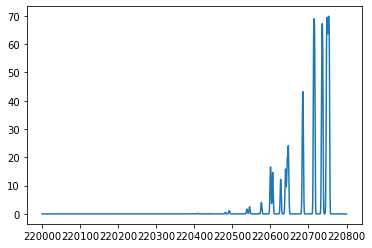

In [4]:
xaxis, yaxis = modeldata.T
pl.plot(xaxis, yaxis)

In [5]:
from astropy import units as u, constants

In [6]:
xclass_spectrum = pyspeckit.Spectrum(xarr=xaxis*u.MHz, data=yaxis*u.K)

support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


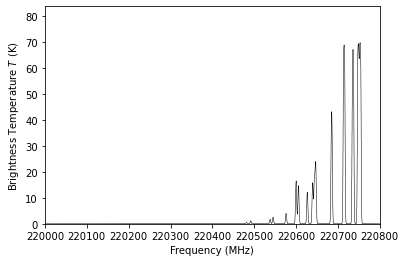

In [7]:
xclass_spectrum.plotter()

In [8]:
source_size =  4.3350376922e+00
tkin = 7.9842254347e+01
Ntot = 1.0061155735e+16
vwidth = 4.2101396644e+00 / np.sqrt(8*np.log(2))
vcen = -7.9000000000e+00

In [9]:
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters, get_molecular_parameters, generate_model, generate_fitter

In [10]:
ch3_13cn_to_ch3cn = 1./16.

In [11]:
freqs, aij, deg, EU, partfunc = get_molecular_parameters('CH3CN, v=0',
                                                         catalog='CDMS',
                                                         fmin=FreqMin*u.MHz,
                                                         fmax=FreqMax*u.MHz)
def modfunc_12c_CDMS(xarr, vcen, width, tex, column, **kwargs):
    model = generate_model(xarr, vcen, width, tex, 
                   column=column, freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
    return model

In [12]:
freqs, aij, deg, EU, partfunc = get_molecular_parameters('CH3CN',
                                                         catalog='JPL',
                                                         fmin=FreqMin*u.MHz,
                                                         fmax=FreqMax*u.MHz)
freqs13, aij13, deg13, EU13, partfunc13 = lte_molecule.get_molecular_parameters('CH3C-13-N',
                                                                                catalog='JPL',
                                                         fmin=FreqMin*u.MHz,
                                                         fmax=FreqMax*u.MHz)
def modfunc_12c(xarr, vcen, width, tex, column, **kwargs):
    model = generate_model(xarr, vcen, width, tex, 
                   column=column, freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
    return model

def modfunc_13c(xarr, vcen, width, tex, column, **kwargs):
    model = generate_model(xarr, vcen, width, tex, 
                   column=column*ch3_13cn_to_ch3cn, freqs=freqs13, aij=aij13, deg=deg13, EU=EU13, partfunc=partfunc13)
    return model


def modfunc(xarr, vcen, width, tex, column, **kwargs):
    join = np.concatenate
    model = generate_model(xarr, vcen, width, tex, 
                   column=join([np.ones_like(deg)*column, np.ones_like(deg13)*column*ch3_13cn_to_ch3cn]),
                   freqs=join([freqs, freqs13]),
                   aij=join([aij, aij13]),
                   deg=join([deg, deg13]),
                   EU=join([EU, EU13]),
                   partfunc=join([np.ones_like(deg)*partfunc(tex), np.ones_like(deg13)*partfunc13(tex)])
                  )
    return model
    
fitter = generate_fitter(modfunc, name="CH3CN")

In [13]:
model12cdms = pyspeckit.Spectrum(xarr=xclass_spectrum.xarr, data=modfunc_12c_CDMS(xclass_spectrum.xarr, vcen, vwidth, tkin, Ntot, ))

model12 = pyspeckit.Spectrum(xarr=xclass_spectrum.xarr, data=modfunc_12c(xclass_spectrum.xarr, vcen, vwidth, tkin, Ntot, ))
model13 = pyspeckit.Spectrum(xarr=xclass_spectrum.xarr, data=modfunc_13c(xclass_spectrum.xarr, vcen, vwidth, tkin, Ntot, ))
model = pyspeckit.Spectrum(xarr=xclass_spectrum.xarr, data=modfunc(xclass_spectrum.xarr, vcen, vwidth, tkin, Ntot, ))

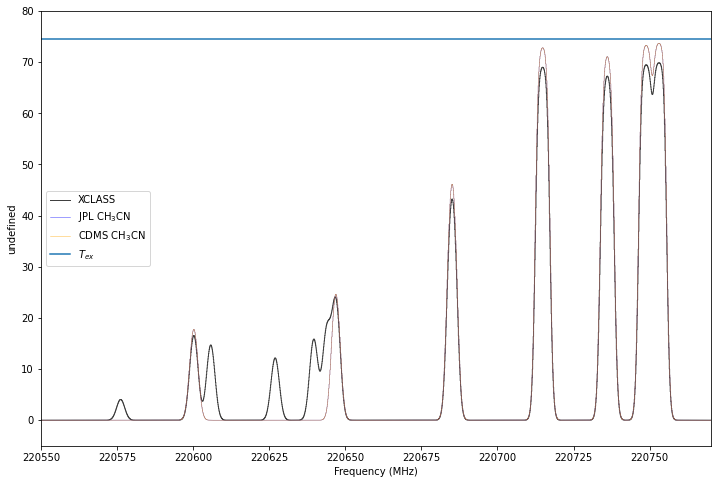

In [14]:
fig = pl.figure(figsize=(12,8))
xclass_spectrum.plotter(alpha=0.75, figure=fig, label='XCLASS', linewidth=1, zorder=-5)
ax = xclass_spectrum.plotter.axis
#model.plotter(clear=False, color='r', axis=ax, alpha=0.75, label='JPL')
model12.plotter(clear=False, color='b', axis=ax, alpha=0.75, label='JPL CH$_3$CN')
#model13.plotter(clear=False, color='g', axis=ax, alpha=0.75, label='JPL CH$_3$$^{13}$CN')
model12cdms.plotter(clear=False, color='orange', axis=ax, alpha=0.75, label='CDMS CH$_3$CN')

ax.axhline(lte_molecule.Jnu_cgs(220.65e9, tkin) - lte_molecule.Jnu_cgs(220.65e9, 2.73), label='$T_{ex}$')
ax.set_xlim(220550, 220770)
ax.set_ylim(-5, 80)
pl.legend(loc='best')